# Is GPT 2 sensitive to violations of Western time metaphors?

Amy Tan

## Background
All languages have the capability to deal with the concept and issue of time, including duration, deictic time, and sequence time. Most commonly, languages use the metaphor "time as space" in order to effectively communicate about the topic. However, they vary in how they handle time in terms of grammatical resources, the type of metaphorical models used, and their cultural practices. In particular, Western languages most commonly use a longitudinal axis with a front (future) - back (past) orientation with a much less common lateral axis with a left (past) - right (future) orientation. Rarer still is a vertical axis with a up (future) - down (past) orientation.<a name="cite_ref-1"></a>[<sup>1</sup>](#cite_note-1) The longitudinal axis shows up in phrases such as "the weeks ahead of us" or "the worst is behind us," the lateral axis shows up in phrases like "next week", and the vertical axis shows up in phrases like "Stories passed down from generation to generation." These metaphors even extend beyond language into our embodied cognition. Studies involving time and gesture showed congruency with these metaphors - words like "tomorrow" were accompanied by gestures forwards or to the right while words like "yesterday" were accompanied by gestures behind or to the left.<a name="cite_ref-2"></a>[<sup>2</sup>](#cite_note-2) Thus, for a native speaker of English, a sentence such as "That was way back in 1900" fits with the metaphors we use for time far better than a sentence such as "That was way forward in 1900", or "That was way down in 1900".<a name="cite_ref-1"></a>[<sup>1</sup>](#cite_note-1) The later two sentences would be what I am considering a violation of
Western time metaphors for this project. Thus, I aim to explore whether or not a Large Language Model (LLM), GPT-2 specifically, is sensitive to violations of Western time metaphors.

---

## General Imports and Libararies 

I first began by installing the transformers library and imported a variety of packages

In [1]:
# %pip install transformers
# %pip install torch
import torch
import transformers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.stats import ttest_ind

Afterwards, I loaded in the GPT-2 model.

In [2]:
gpt2 = transformers.AutoModelForCausalLM.from_pretrained("gpt2")
gpt2.eval()

/Users/amytan/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

Following that, I loaded in the tokenizer that GPT-2 uses in order to prepare text input so the
LLM can actually use it.

In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")

---

## Stimulus Pairs

I created a set of 10 stimulus pairs, stored in the list ```stimuli```. Each item in the list is organized as the sentence, the final word that completes the sentence (the time metaphor), and whether or not the final word is a violation of Western time metaphors (Yes/No). I kept final words for the same sentence within the same axis for consistency - up/down, forward/back. I did not include words from the lateral left/right axis as it was difficult to find/create examples where these sentences ended with the metaphor - I expand upon this in stimulus limitations below. I drew inspiration from various examples from the book, Time in Space.<a name="cite_ref-3"></a>[<sup>3</sup>](#cite_note-3) I then turned the list into a data frame to use in calculating surprisal.

In [4]:
# in the format: (sentence, final word, violation)
stimuli = [
    ("The new year is coming", " up", "No"),
    ("The new year is coming", " down", "Yes"),
    ("This necklace was my moms', I want to give it to my daughter to pass it", "down", "No"),
    ("This necklace was my mom's, I want to give it to my daughter to pass it", "up", "Yes"),
    ("I'm trying plan what I want as a career and look", " ahead", "No"),
    ("I'm trying plan what I want as a career and look", " back", "Yes"),
    ("I looked at old photos from childhood, they made me think", " back", "No"), 
    ("I looked at old photos from childhood, they made me think", " ahead", "Yes"), 
    ("The future is", " ahead", "No"),
    ("The future is", " behind", "Yes"),
    ("The past is", " behind", "No"),
    ("The past is", " ahead", "Yes"),
    ("Now that it's November, the end of the year is getting", " closer", "No"),
    ("Now that it's November, the end of the year is getting", " further", "Yes"),
    ("You're getting ahead of yourself - you're only 12, college is", " further", "No"),
    ("You're getting ahead of yourself - you're only 12, college is", " closer", "Yes"),
    ("We need to harvest the crops soon, winter is", " approaching", "No"),
    ("We need to harvest the crops soon, winter is", " leaving", "Yes"),
    ("The weather is getting colder and summer is", " leaving", "No"),
    ("The weather is getting colder and summer is", " approaching", "No")
]

In [5]:
df_stimuli = pd.DataFrame(stimuli, columns = ['Sentence', 'Word', 'Violation'])
df_stimuli.head()

,Sentence,Word,Violation
0,The new year is coming,up,No
1,The new year is coming,down,Yes
2,"This necklace was my moms', I want to give it ...",down,No
3,"This necklace was my mom's, I want to give it ...",up,Yes
4,I'm trying plan what I want as a career and look,ahead,No


### Limitations of the Stimuli

It's important to note that the set of stimuli I created are only fit for predicting the final word in a given sentence. Thus, I did not include sentences where the time metaphor words would have been embedded in the middle of the sentence (i.e. "That's later down the line") and was unable to include stimuli from the lateral (left/right axis). Had I included these sorts of sentence structures, they might have produced different surprisal values in the following section. Additionally, it's worth noting that understanding whether or not a given word is a violation in its given context relies on general world knowledge. For example, the sentence "The weather is getting colder and summer is," requires knowledge that the weather during summer is warmer - when the weather changes during the season and becomes colder, it typically occurs at its end. Thus, some of the results seen might because the LLM does not have this general world knowledge, rather than because it is/isn't senstive to Western time metaphors.

--- 
## Suprisal and Results

After defining stimulus pairs, I then calculated the suprisal for all target words, given the context (sentence) that they occured in.

In [6]:
def surprisal(p):
    return -np.log2(p)

In [7]:
def next_seq_prob(model, tokenizer, seen, unseen):
    """
    Get p(unseen | seen)
    
    Parameters
    ----------
    model : transformers.PreTrainedModel
    Model to use for predicting tokens
    tokenizer : transformers.PreTrainedTokenizer
    Tokenizer for Model
    seen : str
    Input sequence
    unseen: str
    The sequence for which to calculate a probability
    """
    
    # Get ids for tokens
    input_ids = tokenizer.encode(seen, return_tensors="pt")
    unseen_ids = tokenizer.encode(unseen)
    
    # Loop through unseen tokens & store log probs
    log_probs = []
    for unseen_id in unseen_ids:
        
        # Run model on input
        with torch.no_grad():
            logits = model(input_ids).logits
        
        # Get next token prediction logits
        next_token_logits = logits[0, -1]
        next_token_probs = torch.softmax(next_token_logits, 0) # Normalize
        
        # Get probability for relevant token in unseen string & store
        prob = next_token_probs[unseen_id]
        log_probs.append(torch.log(prob))
        
        # Add input tokens incrementally to input
        input_ids = torch.cat((input_ids, torch.tensor([[unseen_id]])), 1)
        
    # Add log probs together to get total log probability of sequence
    total_log_prob = sum(log_probs)
    # Exponentiate to return to probabilities
    total_prob = torch.exp(total_log_prob)
    return total_prob.item()

In [8]:
results = []

for index, row in tqdm(df_stimuli.iterrows(), total=df_stimuli.shape[0]):
    prob = next_seq_prob(gpt2, tokenizer, row['Sentence'], row['Word'])
    results.append({
        'Word': row['Word'],
        'Sentence': row['Sentence'],
        'Violation': row['Violation'],
        'Probability': prob,
        'Surprisal': surprisal(prob)
    })

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 25.68it/s]


Following that, I turned my results into a data frame and then plotted the Violation and Surprisal columns to visualize if GPT-2 was sensitive to violations of Western time metaphors.

In [9]:
df_results = pd.DataFrame(results)
df_results.head()

,Word,Sentence,Violation,Probability,Surprisal
0,up,The new year is coming,No,9.589426e-02,3.382412
1,down,The new year is coming,Yes,1.034237e-02,6.595290
2,down,"This necklace was my moms', I want to give it ...",No,6.483899e-07,20.556635
3,up,"This necklace was my mom's, I want to give it ...",Yes,1.555292e-07,22.616312
4,ahead,I'm trying plan what I want as a career and look,No,1.716744e-02,5.864181


/var/folders/lp/wvqcc0x13jjb99jsy0mqncqr0000gn/T/ipykernel_85681/2176993993.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_results, x = "Violation", y = "Surprisal", palette = ["orange", "green"])


Text(0.5, 1.0, 'Surprisal for Time Metaphors Higher for Violations')

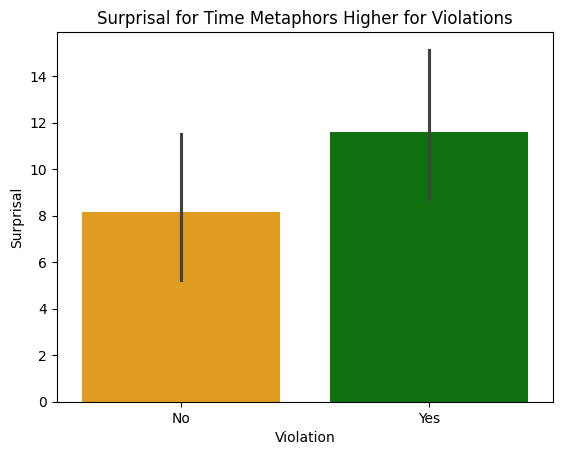

In [10]:
sns.barplot(data = df_results, x = "Violation", y = "Surprisal", palette = ["orange", "green"])
plt.title('Surprisal for Time Metaphors Higher for Violations')

In [11]:
# Print the surprisal mean and standard devation of the Non-Violation condition
not_violation = df_results[df_results['Violation'] == 'No']
print(not_violation['Surprisal'].mean())
print(not_violation['Surprisal'].std())

8.158675900099498
5.602904970765619


In [12]:
# Print the surprisal mean and standard devation of the Violation condition
violation = df_results[df_results['Violation'] == 'Yes']
print(violation['Surprisal'].mean())
print(violation['Surprisal'].std())

11.61840856103569
5.0835060964262215


If we run a t-test, we find that these means are not statistically different using an alpha level of 0.05(t = -1.43, p = 0.17, df = 18). Thus, LLMs are not sensitive to time violations of Western time metaphors.

In [13]:
ttest_ind(not_violation['Surprisal'], violation['Surprisal'])

TtestResult(statistic=-1.4312106893707914, pvalue=0.16950360776416848, df=18.0)

## Discussion
GPT-2 in particular is not sensitive to violations of Western time metaphors, indicating that it lacks the same capacities that humans do for this part of language. It is important to note however, that this does not mean that LLMs as a whole are entirely insensitive. Using these stimuli with newer and more powerful LLMs might yield significant results as the field of LLMs continue to improve. Additionally, follow up using stimuli with the time metaphor embedded or even perhaps at the beginning of sentences would provide a more well rounded understanding of LLMs sensitivity to violations of time-metaphors. 

Additionally, the insensitivity to time metaphor violations demonstrates human cognition's capacity and sensitivity to them. A violation of them in a sentence is confusing and incongruous to our embodied perspective and understanding of time. Time and its metaphors are not only constantly talked about in day-to-day conversation, but we also "feel" time through its simultaneity, its duration, remembered events, and predicted events to name a few.<a name="cite_ref-1"></a>[<sup>1</sup>](#cite_note-1) We encorporate these metaphors into our gestures and cannot ignore spatial cues when asked to make time judgments.<a name="cite_ref-4"></a>[<sup>4</sup>](#cite_note-4) Thus, perhaps due to this consistent exposure to time metaphors and our embodied perespective of it, humans have access to and a fluidity in information that a LLM cannot necessarily get in its training data.

## References


1. <a name="cite_note-1"></a> [^](#cite_ref-1) Radden, G. (2003). The metaphor TIME AS SPACE across languages. Zeitschrift für interkulturellen Fremdsprachenunterricht, 8(2).
2. <a name="cite_note-2"></a> [^](#cite_ref-2) Walker, E., & Cooperrider, K. (2016). The Continuity of Metaphor: Evidence From Temporal Gestures. Cognitive Science, 40(2), 481-495. https://doi.org/10.1111/cogs.12254
3. <a name="cite_note-3"></a> [^](#cite_ref-3) Duffy, S. E., & Feist, M. I. (2023). Time in Space: Cross-Linguistic Variation and Metaphor. In Time, Metaphor, and Language: A Cognitive Science Perspective (pp. 50– 81). chapter, Cambridge: Cambridge University Press.
4. <a name="cite_note-3"></a> [^](#cite_ref-3) Cooperridder, K., & Núñez, R.(2016). How We Make Sense of Time. Scientific American.